### Imports
---

In [1]:
import ast
import numpy as np
import json
import torch
import mace
import matplotlib
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm

from mace.tools import torch_geometric
from mace.data  import HDF5Dataset

---
### Definitions
---

In [2]:
device = 'cuda:3'
model_path = 'data-train-result-256/MACE_MPtrj_2022.9.model'

---
### Load data
---

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
with open('data-train-preprocessed/statistics.json', "r") as f:
    statistics = json.load(f)

zs_list = ast.literal_eval(statistics["atomic_numbers"])
z_table = mace.tools.get_atomic_number_table_from_zs(zs_list)

In [5]:
model = torch.load(model_path)
model = model.to(device)

In [6]:
train_set = HDF5Dataset(
    'data-train-preprocessed/train.h5', r_max=4.5, z_table = z_table,
)
valid_set = HDF5Dataset(
    'data-train-preprocessed/valid.h5', r_max=4.5, z_table = z_table,
)

In [7]:
train_loader = torch_geometric.dataloader.DataLoader(
    dataset=train_set,
    batch_size=128,   
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=1,
)
valid_loader = torch_geometric.dataloader.DataLoader(
    dataset=valid_set,
    batch_size=128,   
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=1,
)

---
### Collect groundtruth and predictions
---

In [8]:
energy_true = []
energy_pred = []

forces_true = [[], [], []]
forces_pred = [[], [], []]

stress_true = [[], [], [], [], [], [], [], [], []]
stress_pred = [[], [], [], [], [], [], [], [], []]

# n = 100
n = len(valid_loader)

for i, batch in tqdm(enumerate(valid_loader), total=n):
    if i >= n:
        break

    batch = batch.to(device)
    batch_dict = batch.to_dict()
    output = model(
        batch_dict,
        training=False,
        compute_force=True,
        compute_virials=True,
        compute_stress=True,
    )

    energy_true.extend([ e.item() for e in batch ['energy'] ])
    energy_pred.extend([ e.item() for e in output['energy'] ])

    for i in range(3):

        forces_true[i].extend([ f[i].item() for f in batch ['forces'] ])
        forces_pred[i].extend([ f[i].item() for f in output['forces'] ])

    for i in range(3):

        for j in range(3):

            k = i*3 + j

            stress_true[k].extend([ s[i][j].item() for s in batch ['stress'] ])
            stress_pred[k].extend([ s[i][j].item() for s in output['stress'] ])


100%|██████████| 618/618 [11:16<00:00,  1.09s/it]


---
### Energy parity plot
---

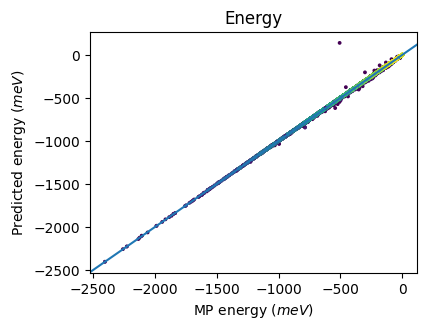

In [9]:
title = r'Energy'

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
fig.tight_layout()

xy = np.vstack([energy_true, energy_pred])
z = scipy.stats.gaussian_kde(xy)(xy)

ax.scatter(energy_true, energy_pred, c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
ax.axline((0,0), slope=1)
ax.set_title(title)
ax.set_xlabel(r'MP energy ($meV$)')
ax.set_ylabel(r'Predicted energy ($meV$)')

plt.show()

---
### Forces parity plot
---

/tmp/ipykernel_3561299/2695052137.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(forces_true[i], forces_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())


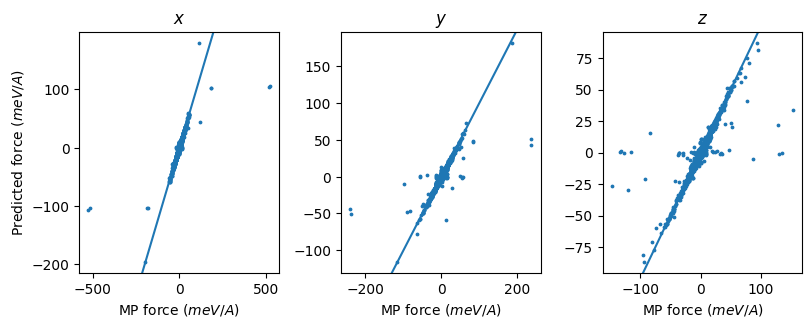

In [10]:
titles = [r'$x$', r'$y$', r'$z$']

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):

    #xy = np.vstack([forces_true[i], forces_pred[i]])
    #z = scipy.stats.gaussian_kde(xy)(xy)

    #ax.scatter(forces_true[i], forces_pred[i], c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.scatter(forces_true[i], forces_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.axline((0,0), slope=1)
    ax.set_title(titles[i])
    ax.set_xlabel(r'MP force ($meV/A$)')
    if i == 0:
        ax.set_ylabel(r'Predicted force ($meV/A$)')

plt.show()

---
### Stress parity plot
---

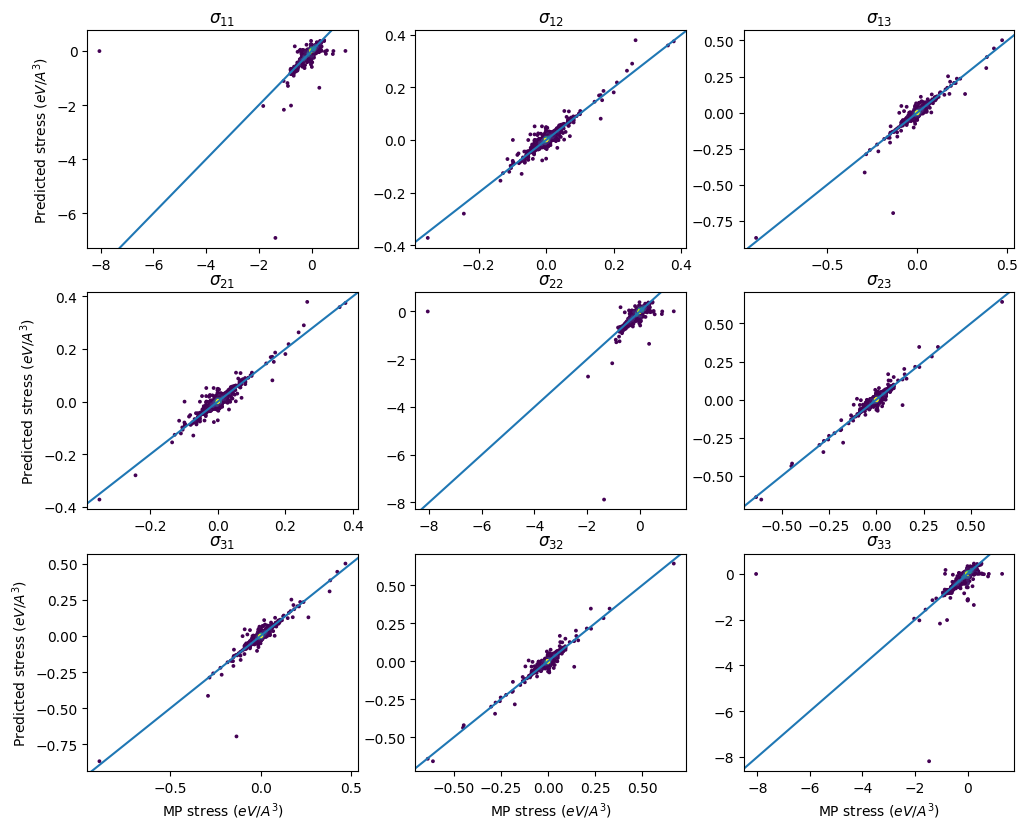

In [11]:
titles = [r'$\sigma_{11}$', r'$\sigma_{12}$', r'$\sigma_{13}$',
          r'$\sigma_{21}$', r'$\sigma_{22}$', r'$\sigma_{23}$',
          r'$\sigma_{31}$', r'$\sigma_{32}$', r'$\sigma_{33}$']

fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):

    xy = np.vstack([stress_true[i], stress_pred[i]])
    z = scipy.stats.gaussian_kde(xy)(xy)

    ax.scatter(stress_true[i], stress_pred[i], c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.axline((0,0), slope=1)
    ax.set_title(titles[i])
    if i in [6, 7, 8]:
        ax.set_xlabel(r'MP stress ($eV/A^3$)')
    if i in [0, 3, 6]:
        ax.set_ylabel(r'Predicted stress ($eV/A^3$)')

plt.show()